<a href="https://colab.research.google.com/github/veiro/master-tesis-data-imputation/blob/master/imputacion/6_sk_imputer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Imputing missing values before building an estimator
- imputation by the constant value 0
- imputation by the mean value of each feature combined with a missing-ness
  indicator auxiliary variable
- k nearest neighbor imputation
- iterative imputation



In [ ]:
# Authors: Maria Telenczuk  <https://github.com/maikia>
# License: BSD 3 clause

# Configuracion

In [ ]:
USAR_GOOGLE_DRIVE =  True
MODO_DESARROLLO = True



In [ ]:
import os
import random
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm


#Descarga de datos y preprocesamiento





In [ ]:
%%time
if (USAR_GOOGLE_DRIVE):
  drive.mount('/content/gdrive')
  PATH_DATA_PROCESADA = "/content/gdrive/MyDrive/Maestria/Tesis/Codigo/data/data-procesada"
else:
  PATH_DATA_PROCESADA = "/mnt"


data_filepath = PATH_DATA_PROCESADA+'/csse_covid_19_data.csv'
data_full = pd.read_csv(data_filepath)
data_sin_columnas_completas = data_full.drop(['FIPS', 'Admin2', 'Recovered', 'Active', 'Combined_Key'], axis=1)
data_sin_null = data_sin_columnas_completas.dropna(subset=['Province_State', 'Lat', 'Long_', 'Incident_Rate', 'Case_Fatality_Ratio'])

if(MODO_DESARROLLO):
   data_utilizar = data_sin_null.sample(n=10000, random_state=1)
else:
  data_utilizar = data_sin_null

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
CPU times: user 7.66 s, sys: 2.24 s, total: 9.9 s
Wall time: 13 s


In [ ]:
data_utilizar.head(5)

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Incident_Rate,Case_Fatality_Ratio,date
551300,Indiana,US,2021-05-18 04:20:33,40.769410,-86.045250,3839,68,10809.212749,1.771295,05-17-2021
3033333,Louisiana,US,2023-01-26 04:20:59,32.090252,-92.117521,4403,55,44394.031055,1.249148,01-25-2023
398514,Georgia,US,2021-04-10 04:20:59,34.002671,-85.186778,5496,89,12897.472602,1.619360,04-09-2021
2086141,Nebraska,US,2022-06-04 04:20:58,40.524520,-101.060357,96,0,10412.147505,0.000000,06-03-2022
2367680,Ohio,US,2022-08-13 04:20:52,41.116763,-84.580102,5025,74,26911.953728,1.472637,08-12-2022


# Enconding data

In [ ]:
# variables gloables
encoded_df_Country_Region_cols = 0
encoderOHE = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoderLE1 = LabelEncoder()
encoderLE2 = LabelEncoder()
encoderLE3 = LabelEncoder()



# ENCODING
# 1- onehotenconding de Country_Region
df=data_utilizar

encoded_data = encoderOHE.fit_transform( df[['Country_Region']])
encoded_df_Country_Region = pd.DataFrame(encoded_data, columns=encoderOHE.get_feature_names_out(['Country_Region']))
encoded_df_Country_Region_cols = encoded_df_Country_Region.shape[1]

df = df.drop(['Country_Region'], axis=1)

# hice este concat horrible por que por alguna razon no me andaba bien el concant ordinario
pos = encoded_df_Country_Region_cols
for col in df.columns:
  encoded_df_Country_Region.insert( pos, col, df[col].to_numpy(), True)
  pos=pos+1

df = encoded_df_Country_Region

# 2 Province_State, Last_Update, date
df['Province_State_encoded'] = encoderLE1.fit_transform(df['Province_State'])
df = df.drop(['Province_State'], axis=1)

df['Last_Update_encoded'] = encoderLE2.fit_transform(df['Last_Update'])
df = df.drop(['Last_Update'], axis=1)

df['date_encoded'] = encoderLE3.fit_transform(df['date'])
df = df.drop(['date'], axis=1)
  #return df,  encoded_df_Country_Region_cols

data=df

data = data.reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Agrego nulls artificialmente

In [ ]:
def missing_method(raw_data) :
    # caso: MCAR
    d = raw_data.copy()
    rows, cols = data.shape

    # missingness threshold
    t = 0.2

    # uniform random vector
    v = np.random.uniform(0., 1.,size=(rows, cols))

    # missing values where v<=t
    mask = (v<=t)
    d[mask] = np.nan
    return d, mask

missed_data , mask= missing_method(data)


In [ ]:
mask

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ...,  True, False, False]])

In [ ]:
missed_data.head()


,Country_Region_Australia,Country_Region_Belgium,Country_Region_Brazil,Country_Region_Canada,Country_Region_Chile,Country_Region_China,Country_Region_Colombia,Country_Region_Denmark,Country_Region_France,Country_Region_Germany,...,Country_Region_United Kingdom,Lat,Long_,Confirmed,Deaths,Incident_Rate,Case_Fatality_Ratio,Province_State_encoded,Last_Update_encoded,date_encoded
0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,...,0.0,40.769410,-86.045250,3839.0,68.0,10809.212749,1.771295,186.0,138.0,340.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,32.090252,-92.117521,4403.0,55.0,44394.031055,1.249148,260.0,NaN,74.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,34.002671,-85.186778,5496.0,NaN,NaN,NaN,143.0,NaN,264.0
3,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,-101.060357,96.0,0.0,NaN,0.000000,NaN,NaN,375.0
4,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,NaN,-84.580102,5025.0,74.0,NaN,NaN,354.0,594.0,515.0


# Utils

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



df_resultados = pd.DataFrame(columns=['Strategy', 'rmse'])
df_resultados = df_resultados.append({ 'Strategy':'MIDA', 'rmse': 4.574} , ignore_index = True)
df_resultados = df_resultados.append({ 'Strategy':'GAIN', 'rmse': 1.693} , ignore_index = True)

def decode(imputed_data):

  df = pd.DataFrame(imputed_data, columns = data.columns)
  # DECODE
  # 1- onehotenconding de Country_Region.
  encoded_df_Country_Region = df.iloc[:,  :encoded_df_Country_Region_cols]
  df['Country_Region'] = encoderOHE.inverse_transform(encoded_df_Country_Region)
  df.drop(columns=df.columns[:encoded_df_Country_Region_cols], axis=1,  inplace=True)


  #2- Province_State, Last_Update, date

  Province_State_encoded_count = data.Province_State_encoded.unique().tolist().count(1)
  Last_Update_encoded_count = data.Last_Update_encoded.unique().tolist().count(1)
  date_encoded_encoded_count = data.date_encoded.unique().tolist().count(1)


  df['Province_State_encoded'] = df['Province_State_encoded'].astype(int)
  df['date_encoded'] = df['date_encoded'].astype(int)
  df['Last_Update_encoded'] = df['Last_Update_encoded'].astype(int)

  for i,  row in tqdm(df.iterrows()):
    # en algunos casos inventa valores que no existen, entonces como es un error le asigno el primero pero puede ser cualquier valor.

    if(row['Province_State_encoded'] >Province_State_encoded_count or row['Province_State_encoded'] <1 ):
      #significa que genero algo que no existe
      df.at[i,'Province_State_encoded'] = 1


    if(row['Last_Update_encoded'] <1 or row['Last_Update_encoded'] > Last_Update_encoded_count ):
      #significa que genero algo que no existe
      df.at[i,'Last_Update_encoded'] = 1


    if(row['date_encoded'] <1 or row['date_encoded'] > date_encoded_encoded_count):
      #significa que genero algo que no existe
      df.at[i,'date_encoded'] = 1

  df['Province_State'] = encoderLE1.inverse_transform(df['Province_State_encoded'].astype(int) )
  df['Last_Update'] = encoderLE2.inverse_transform(df['Last_Update_encoded'].astype(int) )
  df['date'] = encoderLE3.inverse_transform(df['date_encoded'].astype(int) )



  df = df.drop(['Province_State_encoded'], axis=1)
  df = df.drop(['Last_Update_encoded'], axis=1)
  df = df.drop(['date_encoded'], axis=1)

  #3- ordeno columnas

  col = df.pop('Province_State')
  df.insert(0, col.name, col)

  col = df.pop('Country_Region')
  df.insert(1,  col.name, col)

  col = df.pop('Last_Update')
  df.insert(2,  col.name, col)

  # cambio tipo de dato

  df['Confirmed'] = df['Confirmed'].astype(int)

  df['Deaths'] = df['Deaths'].astype(int)


  # cantidad de cifras significativas>

  df["Lat"] = round(df['Lat'],6)
  df["Long_"] = round(df['Long_'],4)


  return df


def guardoResultados(strat, rmse):
  global df_resultados
  print("Strategy: " + strat + ' - RMSE: ' + str(rmse))
  df_resultados = df_resultados.append({ 'Strategy':strat, 'rmse':rmse} , ignore_index = True)

def calc_RMSE(actual , filled, mask ):
  actual = actual.to_numpy()
  filled = filled.to_numpy()
  rmse_sum = 0
  for i in range(actual.shape[1]):
    if actual[:,i].sum() > 0 :
      y_actual = actual[:,i][mask[:,i]]
      y_predicted = filled[:,i][mask[:,i]]
      rmse = sqrt(mean_squared_error(y_actual, y_predicted))
      rmse_sum += rmse
  return rmse_sum

def calcularMetricas(data, imputed_data, mask, strat):
  imputed_data_df = pd.DataFrame(imputed_data, columns = data.columns)
  rmse = calc_RMSE(data,  imputed_data_df, mask)
  guardoResultados(strat, rmse)
  decoded_imputed_data_df =  decode(imputed_data_df)
  decoded_imputed_data_df.to_csv(PATH_DATA_PROCESADA+'/csse_covid_19_data_strategy='+strat+'_'+'Desarrollo='+str(MODO_DESARROLLO)+ '.csv', index=False)






# Imputacion

In [ ]:

from sklearn.impute import SimpleImputer

strategy = ['mean', 'median', 'most_frequent', 'constant']

for strat in strategy:
  imp = SimpleImputer(missing_values=np.nan, strategy=strat)
  imp.fit(missed_data)
  imputed_data = imp.transform(missed_data)
  calcularMetricas(data, imputed_data, mask, strat)
  del imp
  del imputed_data

Strategy: mean - RMSE: 398878.7743682404


2992223it [06:50, 7294.18it/s]


Strategy: median - RMSE: 403500.7544469021


2992223it [06:45, 7387.87it/s]


Strategy: most_frequent - RMSE: 415300.9834006938


2992223it [06:26, 7744.47it/s]


Strategy: constant - RMSE: 415433.3201701274


2992223it [06:36, 7545.78it/s]


In [ ]:
%%time
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(missed_data)
imputed_data=imp.transform(missed_data)
calcularMetricas(data, imputed_data, mask, 'IterativeImputer')
del imp
del imputed_data

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Strategy: IterativeImputer - RMSE: 267937.0895170423


2992223it [06:42, 7438.17it/s]


CPU times: user 1h 29min 27s, sys: 1h 2min 2s, total: 2h 31min 30s
Wall time: 43min 8s


In [ ]:
%%time
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=4, weights="uniform")
imputed_data = imputer.fit_transform(missed_data)

calcularMetricas(data, imputed_data, mask, 'KNNImputer')
del imputer
del imputed_data

#10.000 row => 23.6 seg
# el algoritmo es O(n2)=> en el poer de los casos son dos for anidados de largo n. Explicacion abajo
#2.000.000 row => 400.000.000 seg = 6,666,666.6 min = 111,111.1 hrs estimacion
# The time complexity of the KNN algorithm for a single query point is O(nd), where n is the number of training examples and d is the number of features. This is because for each query point, the algorithm needs to compute the distance between the query point and every other point in the dataset. As the number of features or the size of the dataset increases, the computational complexity of KNN also increases significantly, making it computationally expensive and impractical for large datasets. Additionally, finding the optimal value of k by brute force can also increase the time complexity of the algorithm.
# fuente https://arize.com/blog-course/knn-algorithm-k-nearest-neighbor/#:~:text=The%20time%20complexity%20of%20the,other%20point%20in%20the%20dataset.


Strategy: KNNImputer - RMSE: 333402.7085963819


10000it [00:01, 7757.78it/s]


CPU times: user 22.5 s, sys: 5.93 s, total: 28.5 s
Wall time: 23.6 s


# Plot resultados

<Axes: xlabel='Strategy'>

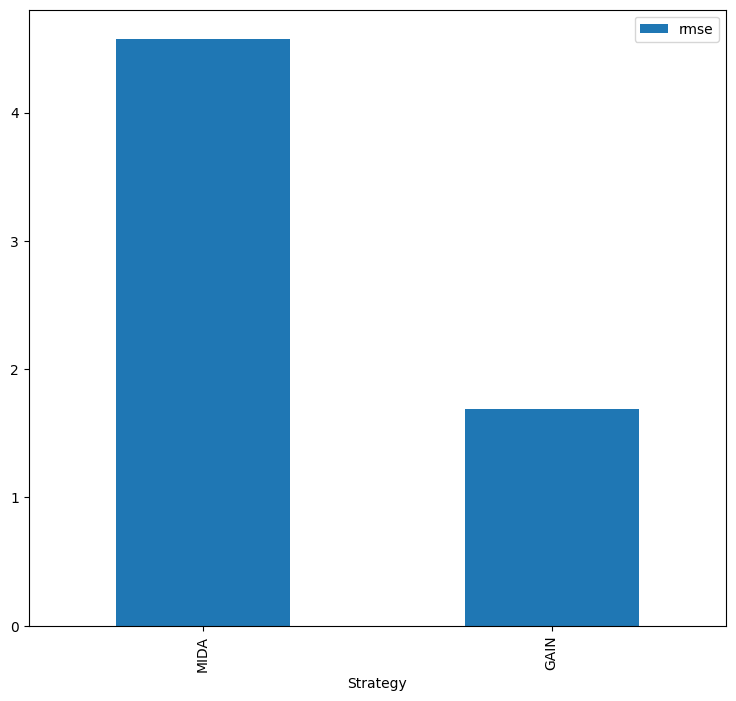

In [ ]:

df_resultados.plot(x='Strategy', y=["rmse"], kind="bar", figsize=(9, 8))

<ipython-input-3-7191f5e3e3e7>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append({ 'Strategy':'MIDA', 'rmse': 4.574} , ignore_index = True)
<ipython-input-3-7191f5e3e3e7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append({ 'Strategy':'GAIN', 'rmse': 1.693} , ignore_index = True)
<ipython-input-3-7191f5e3e3e7>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append({ 'Strategy':'Mean', 'rmse': 398878.774} , ignore_index = True)
<ipython-input-3-7191f5e3e3e7>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.a

<Axes: xlabel='Strategy'>

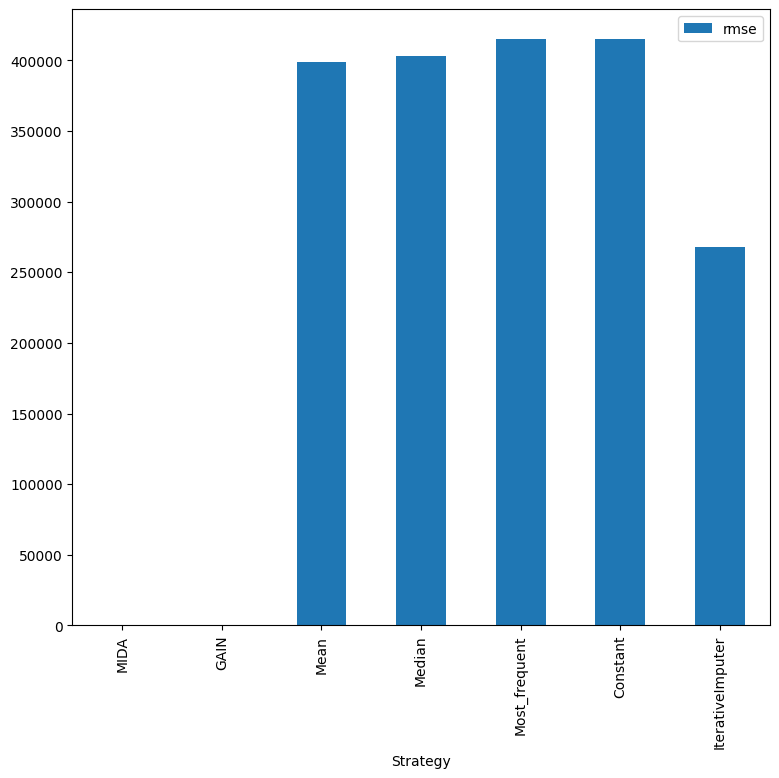

In [ ]:
df_resultados = pd.DataFrame(columns=['Strategy', 'rmse'])
df_resultados = df_resultados.append({ 'Strategy':'MIDA', 'rmse': 4.574} , ignore_index = True)
df_resultados = df_resultados.append({ 'Strategy':'GAIN', 'rmse': 1.693} , ignore_index = True)
df_resultados = df_resultados.append({ 'Strategy':'Mean', 'rmse': 398878.774} , ignore_index = True)
df_resultados = df_resultados.append({ 'Strategy':'Median', 'rmse': 403500.754} , ignore_index = True)
df_resultados = df_resultados.append({ 'Strategy':'Most_frequent', 'rmse': 415300.983} , ignore_index = True)
df_resultados = df_resultados.append({ 'Strategy':'Constant', 'rmse': 415433.320} , ignore_index = True)
df_resultados = df_resultados.append({ 'Strategy':'IterativeImputer', 'rmse': 267937.089} , ignore_index = True)


df_resultados.plot(x='Strategy', y=["rmse"], kind="bar", figsize=(9, 8))

In [ ]:
display(df_resultados)

,Strategy,rmse
0,MIDA,4.574
1,GAIN,1.693
2,Mean,398878.774
3,Median,403500.754
4,Most_frequent,415300.983
5,Constant,415433.320
6,IterativeImputer,267937.089
